In [ ]:
# pip install -U scikit-learn scipy matplotlib
# !pip install seaborn
# !pip install statsmodels

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from math import *
from datetime import datetime

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


# First observation

In [ ]:
target_region = 'Adda'
csv_with_aggreg = "./snow/ARPA_csv/snow_" + target_region + "_with_aggreg_KNN.csv"

# load csv with features
all_features = pd.read_csv(csv_with_aggreg)
all_features

,Date,year,week,cyclostationary_mean_snow,cyclostationary_mean_snow_1w,cyclostationary_mean_snow_4w,cyclostationary_mean_snow_8w,cyclostationary_mean_snow_12w,cyclostationary_mean_snow_16w,cyclostationary_mean_snow_24w
0,2000-01-03,2000,1,-14.431250,-14.431250,-14.431250,-14.431250,-14.431250,-14.431250,-14.431250
1,2000-01-11,2000,2,-19.004500,-16.717875,-16.717875,-16.717875,-16.717875,-16.717875,-16.717875
2,2000-01-19,2000,3,-32.826071,-25.915286,-22.087274,-22.087274,-22.087274,-22.087274,-22.087274
3,2000-01-27,2000,4,-22.364531,-27.595301,-22.156588,-22.156588,-22.156588,-22.156588,-22.156588
4,2000-02-04,2000,5,-36.814375,-29.589453,-25.088146,-25.088146,-25.088146,-25.088146,-25.088146
...,...,...,...,...,...,...,...,...,...,...
908,2019-11-23,2019,47,79.799375,77.836062,53.917118,52.522699,52.619617,52.668000,56.388331
909,2019-12-01,2019,48,74.728571,77.263973,59.437051,55.050138,54.297171,53.962798,56.892924
910,2019-12-09,2019,50,49.498250,62.113411,60.897089,54.969743,54.033796,53.772122,56.310794
911,2019-12-17,2019,51,65.279286,57.388768,69.035646,56.518118,54.984347,54.499014,54.202195


In [ ]:
snow_no_aggreg = all_features.iloc[:,:4]
snow_no_aggreg

,Date,year,week,cyclostationary_mean_snow
0,2000-01-03,2000,1,-14.431250
1,2000-01-11,2000,2,-19.004500
2,2000-01-19,2000,3,-32.826071
3,2000-01-27,2000,4,-22.364531
4,2000-02-04,2000,5,-36.814375
...,...,...,...,...
908,2019-11-23,2019,47,79.799375
909,2019-12-01,2019,48,74.728571
910,2019-12-09,2019,50,49.498250
911,2019-12-17,2019,51,65.279286


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

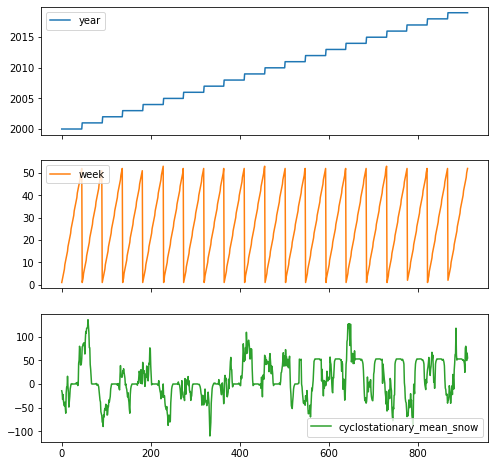

In [ ]:
snow_no_aggreg.plot(subplots=True, figsize=(8,8))

### Regression with incremental index to study mean stationarity

In [ ]:
# we already have cyclostationary means

snow = snow_no_aggreg.iloc[:, 3:4].values

X = snow_no_aggreg.index.values
X = X.reshape(X.shape[0], 1)

#create linear models
regression = LinearRegression()
regression.fit(X, snow)

print('Coefficients snow: \n', '{:.20f}'.format(regression.coef_[0][0]), regression.intercept_[0])

Coefficients snow: 
 0.03888012685735358492 -7.064150867080249


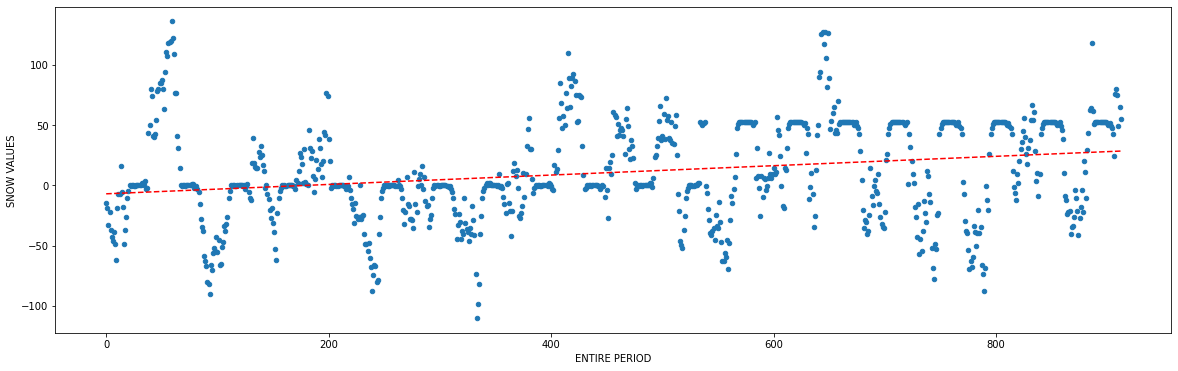

In [ ]:
fig_scat, ax_scat = plt.subplots(1,1, figsize=(20,6))

# Plot best-fit line
best_fit = regression.intercept_ + regression.coef_[0] * X

ax_scat.scatter(X, snow, s=20, label='Data')
ax_scat.plot(X, best_fit, ls='--', label='Best Fit Line', color='red')

ax_scat.set_xlabel('ENTIRE PERIOD')
ax_scat.set_ylabel('SNOW VALUES');

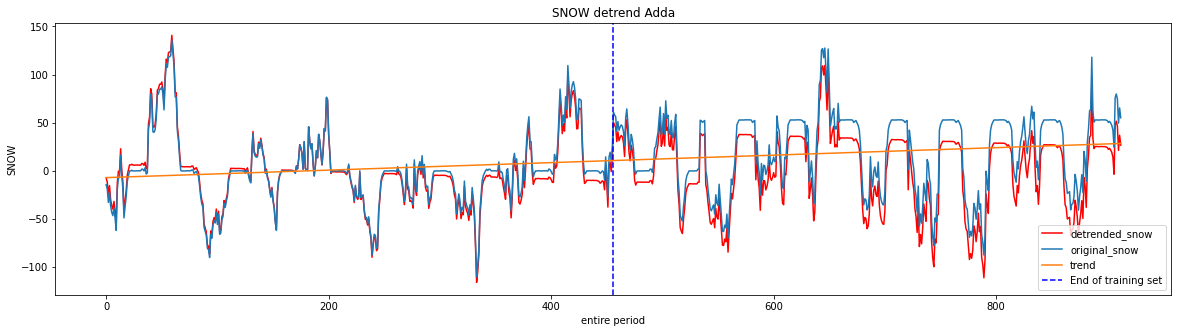

In [ ]:
trend = regression.predict(X) # values of the red dotted line (best fit line) above
detrended = [snow[i]-trend[i] for i in range(0, len(X))]

plt.plot(detrended, color='red', label = "detrended_snow")
plt.plot(snow, label = "original_snow")
plt.plot(trend, label ="trend")
plt.rcParams["figure.figsize"] = (20,5)

plt.xlabel("entire period")
plt.ylabel("SNOW")
plt.title("SNOW detrend Adda")
plt.axvline(x=456, color='b', linestyle='--', label='End of training set')

plt.legend(loc="lower right")

plt.show()

#### Augmented Dickey-Fuller test
for stationarity: p_value < 0.05 and test_stat < critical values

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    result = adfuller(timeseries, autolag="AIC")
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [ ]:
adf_test(snow_no_aggreg.iloc[:, 3:4])

Results of Dickey-Fuller Test:
ADF Statistic: -6.019546
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568


#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
for stationarity: p_value > 0.05 and test_stat < critical values

In [ ]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = '{:.20f}'.format(value)
    print (kpss_output)

In [ ]:
kpss_test(snow_no_aggreg.iloc[:, 3:4]) # FAILED

Results of KPSS Test:
Test Statistic                         0.646203
p-value                                0.018436
#Lags Used                                 18.0
Critical Value (10%)     0.34699999999999997513
Critical Value (5%)      0.46300000000000002265
Critical Value (2.5%)    0.57399999999999995470
Critical Value (1%)      0.73899999999999999023
dtype: object


## One year

In [ ]:
snow_no_aggreg

,Date,year,week,cyclostationary_mean_snow
0,2000-01-03,2000,1,-14.431250
1,2000-01-11,2000,2,-19.004500
2,2000-01-19,2000,3,-32.826071
3,2000-01-27,2000,4,-22.364531
4,2000-02-04,2000,5,-36.814375
...,...,...,...,...
908,2019-11-23,2019,47,79.799375
909,2019-12-01,2019,48,74.728571
910,2019-12-09,2019,50,49.498250
911,2019-12-17,2019,51,65.279286


In [ ]:
snow_no_aggreg['Date'] = pd.to_datetime(snow_no_aggreg['Date'], format = '%Y-%m-%d')
features_last_period = snow_no_aggreg[snow_no_aggreg['Date'] >= datetime.strptime('2019-01-01', '%Y-%m-%d')]
features_last_period.reset_index(drop=True, inplace = True)

In [ ]:
snow = features_last_period.iloc[:, 3:4].values

X = features_last_period.index.values
X = X.reshape(X.shape[0], 1)

#create linear models
regression = LinearRegression()
regression.fit(X, snow)

print('Coefficients snow: \n', '{:.20f}'.format(regression.coef_[0][0]), regression.intercept_[0])

Coefficients snow: 
 2.12295718392449117573 -13.293142170966462


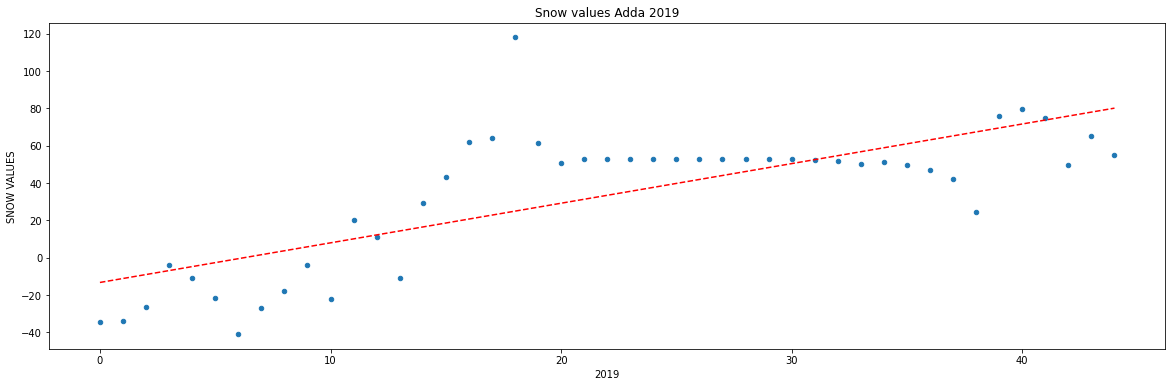

In [ ]:
fig_scat, ax_scat = plt.subplots(1,1, figsize=(20,6))

# Plot best-fit line
best_fit = regression.intercept_ + regression.coef_[0] * X

ax_scat.scatter(X, snow, s=20, label='Data')
ax_scat.plot(X, best_fit, ls='--', label='Best Fit Line', color='red')

ax_scat.set_xlabel('2019')
ax_scat.set_ylabel('SNOW VALUES');
ax_scat.set_title('Snow values Adda 2019');

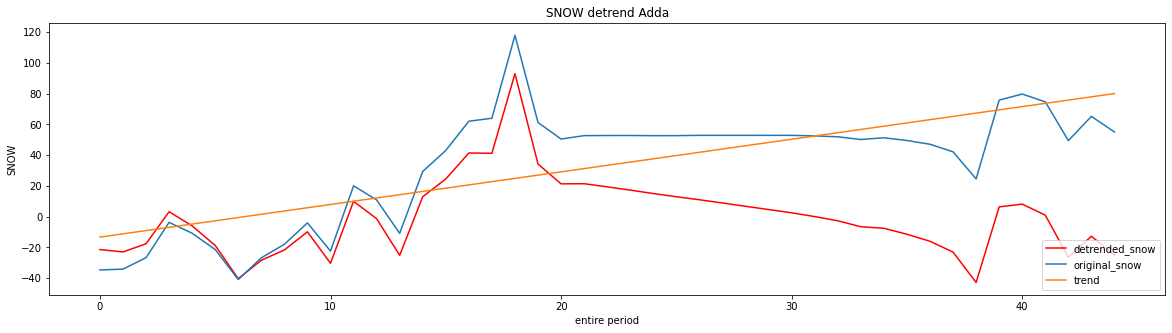

In [ ]:
trend = regression.predict(X) # values of the red dotted line (best fit line) above
detrended = [snow[i]-trend[i] for i in range(0, len(X))]

plt.plot(detrended, color='red', label = "detrended_snow")
plt.plot(snow, label = "original_snow")
plt.plot(trend, label ="trend")
plt.rcParams["figure.figsize"] = (20,5)

plt.xlabel("entire period")
plt.ylabel("SNOW")
plt.title("SNOW detrend Adda")

plt.legend(loc="lower right")

plt.show()

# Ticino snow feature chosen by wrapper best 5

In [11]:
path_features = './NonLinCFA/temp_prec_snow/'
basin = 'Ticino'
train_name = '_wrapper_best5_train_withSnow.csv'
val_name = '_wrapper_best5_val_withSnow.csv'
test_name = '_wrapper_best5_test_withSnow.csv'

features_train = pd.read_csv(path_features + basin + train_name).cyclostationary_mean_HS_12w_1
features_valid = pd.read_csv(path_features + basin + val_name).cyclostationary_mean_HS_12w_1
features_test = pd.read_csv(path_features + basin + test_name).cyclostationary_mean_HS_12w_1

In [17]:
snow = features_train.values

X = features_train.index.values
X = X.reshape(X.shape[0], 1)

#create linear models
regression = LinearRegression()
regression.fit(X, snow)

print('Coefficients snow: \n', '{:.20f}'.format(regression.coef_[0]), regression.intercept_)

Coefficients snow: 
 0.00127678046793445587 -0.26173999592656344


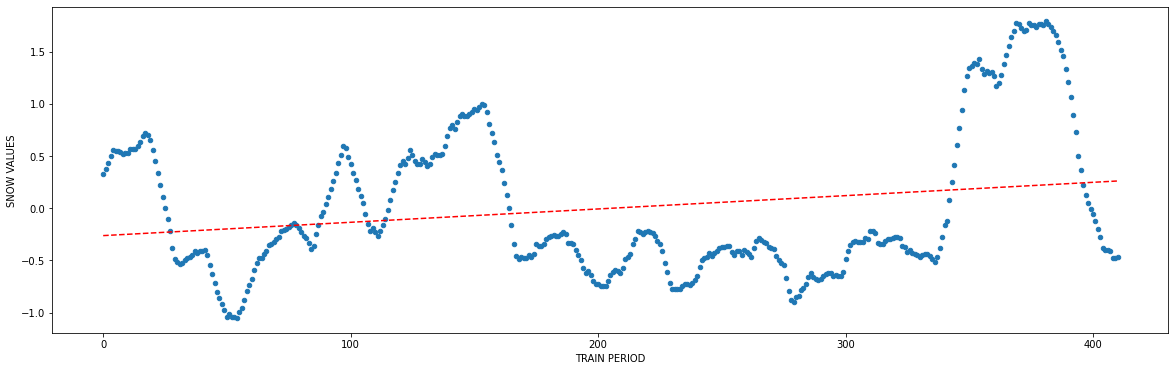

In [18]:
fig_scat, ax_scat = plt.subplots(1,1, figsize=(20,6))

# Plot best-fit line
best_fit = regression.intercept_ + regression.coef_[0] * X

ax_scat.scatter(X, snow, s=20, label='Data')
ax_scat.plot(X, best_fit, ls='--', label='Best Fit Line', color='red')

ax_scat.set_xlabel('TRAIN PERIOD')
ax_scat.set_ylabel('SNOW VALUES');

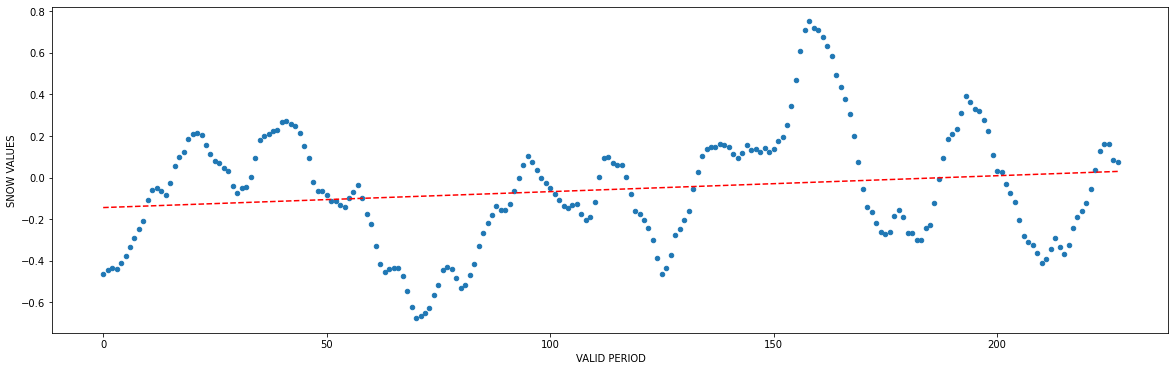

In [19]:
snow = features_valid.values

X = features_valid.index.values
X = X.reshape(X.shape[0], 1)

#create linear models
regression = LinearRegression()
regression.fit(X, snow)

fig_scat, ax_scat = plt.subplots(1,1, figsize=(20,6))
best_fit = regression.intercept_ + regression.coef_[0] * X
ax_scat.scatter(X, snow, s=20, label='Data')
ax_scat.plot(X, best_fit, ls='--', label='Best Fit Line', color='red')
ax_scat.set_xlabel('VALID PERIOD')
ax_scat.set_ylabel('SNOW VALUES');

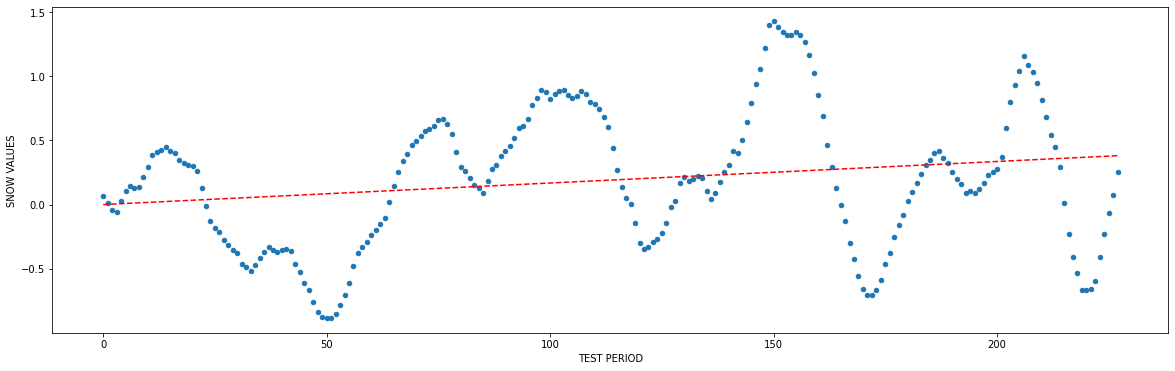

In [20]:
snow = features_test.values

X = features_test.index.values
X = X.reshape(X.shape[0], 1)

#create linear models
regression = LinearRegression()
regression.fit(X, snow)

fig_scat, ax_scat = plt.subplots(1,1, figsize=(20,6))
best_fit = regression.intercept_ + regression.coef_[0] * X
ax_scat.scatter(X, snow, s=20, label='Data')
ax_scat.plot(X, best_fit, ls='--', label='Best Fit Line', color='red')
ax_scat.set_xlabel('TEST PERIOD')
ax_scat.set_ylabel('SNOW VALUES');